# Models Notebook

This notebook is comprised of two sections:
* Exploratory Data Analysis

    This section takes a look at the training and testing images that we will be working with.

* Convolutional Neural Networks (CNNs)

    This section implements a custom CNN for image classification as well as trains both finetuned ResNet and VGG16 models for comparison.

## Exploratory Data Analysis

In [ ]:
###### uncomment the following 4 lines before initially running this notebook ########

# %pip install --upgrade pip
# %pip install PIL
# %pip install nbconvert PyPDF2
# %pip install torchvision

In [151]:
import os
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

In [170]:
## paths to different image folders
PATH_TO_TRAINING_FLIP = str(Path('images/training/flip'))
PATH_TO_TRAINING_NOTFLIP = str(Path('images/training/notflip'))
PATH_TO_TESTING_FLIP = str(Path('images/testing/flip'))
PATH_TO_TESTING_NOTFLIP = str(Path('images/testing/notflip'))

In [165]:
## lists of different training/testing images

train_flip = os.listdir(PATH_TO_TRAINING_FLIP)
train_notflip = os.listdir(PATH_TO_TRAINING_NOTFLIP)
test_flip = os.listdir(PATH_TO_TESTING_FLIP)
test_notflip = os.listdir(PATH_TO_TESTING_NOTFLIP)

path_dict = {
    'training_flip': PATH_TO_TRAINING_FLIP,
    'training_noflip': PATH_TO_TRAINING_NOTFLIP,
    'testing_flip': PATH_TO_TESTING_FLIP,
    'testing_noflip': PATH_TO_TESTING_NOTFLIP
}

In [166]:
num_training_images = len(train_flip) + len(train_notflip)
num_test_images = len(test_flip) + len(test_notflip)
print(f"Number of training images: {num_training_images}\nNumber of test images: {num_test_images}")

Number of training images: 2392
Number of test images: 597


In [167]:
flip_total = len(train_flip) + len(test_flip)
print(f"Total images of 'flips': {flip_total}")

Total images of 'flips': 1452


In [168]:
not_flip_total = len(train_notflip) + len(test_notflip)
print(f"Total images of 'non-flips': {not_flip_total}")

Total images of 'non-flips': 1537


In [169]:
flip_percentage = flip_total / (flip_total + not_flip_total)
non_flip_percentage = not_flip_total / (flip_total + not_flip_total)
print(f"Percentage of flip images: {round(flip_percentage, 4)*100}%\nPercentage of non-flip images: {round(non_flip_percentage, 4)*100}%")

Percentage of flip images: 48.58%
Percentage of non-flip images: 51.42%


The dataset has roughly an equal amount of each type of photo.

Now, for a sanity check let us look at the first 5 images in each folder and make sure they are of the same shape for later on.

In [174]:
height = None
width = None

for name, value in path_dict.items():
    print(f"{name}:")
    for i in range(8):
        not_flip_images = os.listdir(value)[i]
        image = mpimg.imread(value+'/'+not_flip_images)
        image_as_array = np.asarray(image)
        print(f"\t{image_as_array.shape}")
    height = image_as_array.shape[0]
    width = image_as_array.shape[1]

training_flip:
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
training_noflip:
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
testing_flip:
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
testing_noflip:
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)
	(1920, 1080, 3)


In [175]:
print(f"Height: {height} || Width: {width}")

Height: 1920 || Width: 1080


Looking at the different folders we can see that sizes of the images look to be uniform!

The heigth and width will be used for inputs to the CNN in the next step.

In [178]:
## function for getting an image for testing purposes throughout the notebook
   
def get_random_training_notflip_image(path_to_images=str(), return_image=False):
    '''
    ---Parameters---
    path_to_images: file path to images

    --Returns---
    An image
    '''

    if path_to_images[-1] != '/':
        path_to_images += '/'

    image_path = Path(path_to_images+'training/notflip')

    images = os.listdir(image_path)
    images_np = np.array(images)

    random_image = np.random.choice(images_np)

    image = mpimg.imread(path_to_images+'training/notflip/'+random_image)
    
    if return_image:
        plt.figure(figsize=(10,10))
        plt.axis('off')
        plt.imshow(image)
        plt.show()
    
    return random_image

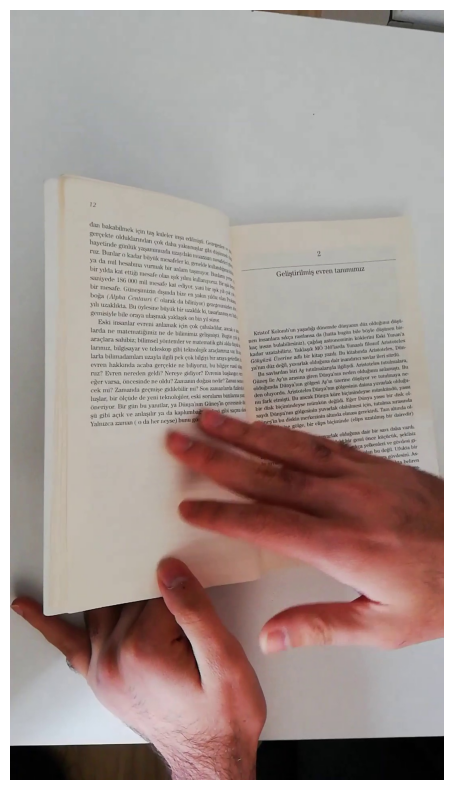

'0038_000000007.jpg'

In [179]:
random_image = get_random_training_notflip_image('images', True)
random_image

In [180]:
## function for cropping images if need be

def resize_images(path_to_images=str()):
    '''
    -- Parameters --
    path_to_images: file path to images that you wish to resize given that the structure of the directory is already in a structure like so:
        images
        |
        |-- training
        |   |
        |   |-- flip
        |   |-- notflip
        |-- testing 
            |
            |-- flip
            |-- notflip

    -- Returns --
    Makes new image folder with same structure as above for cropped images
    '''

    if os.path.exists('cropped_images') != True: ## checks to see if the new folder for the images does not exist
        os.mkdir('cropped_images')               ## if so, it creates a new directory for the cropped images

    for train_test in os.listdir(path_to_images)[1:]:
        
        if os.path.exists(f'cropped_images/{train_test}') != True: ## checks to see if the new train/test folders do not exist
            os.mkdir(f'cropped_images/{train_test}')               ## if so, it creates a new directory for the images

        for flip_notflip in os.listdir(f'{path_to_images}/{train_test}'):
            
            if os.path.exists(f'cropped_images/{train_test}/{flip_notflip}') != True:
                os.mkdir(f'cropped_images/{train_test}/{flip_notflip}/')

            for images in os.listdir(f'{path_to_images}/{train_test}/{flip_notflip}'):
                if os.path.exists(f'cropped_images/{train_test}/{flip_notflip}/{images}') != True:
                    image = str(images)
                    path = f'{path_to_images}/{train_test}/{flip_notflip}/' ## path of existing images
                    image = Image.open(path+image) ## opens each image

                    ## crops image to a smaller size...the third argument is the maximum width of the image
                    ## between 250.0 and 1500.0 is the main image we want to focus on (the text)
                    image = image.crop((0.0, 250.0, image.size[0], 1500.0))

                    image.save(f'cropped_images/{train_test}/{flip_notflip}/{images}')
                else:
                    break
        print()

In [182]:
## function for showing training and testing images side-by-side
def plot_no_flip_images(path_to_images=str(), num_images=int()):
    '''
    ---Parametere---
    path_to_images: file path to images
    num_images: number of images that you would like to be displayed in column form. For example, num_images set to 3 would result in 3 rows of pictures.

    --Returns---
    num_images of train and test images
    '''

    if path_to_images[-1] != '/':
        path_to_images += '/'

    fig1, axs1 = plt.subplots(nrows=num_images, ncols=2, figsize=(8,25))
    axs1[0, 0].set_title('Training Images')
    axs1[0, 1].set_title('Testing Images')   
    plt.axis('off')

    training_not_flip_images = Path(path_to_images+'training/notflip/')
    testing_not_flip_images = Path(path_to_images+'testing/notflip/')

    for i in range(num_images):
        train_image = mpimg.imread(f'{path_to_images}/training/notflip/'+os.listdir(training_not_flip_images)[i])
        test_image = mpimg.imread(f'{path_to_images}/testing/notflip/'+os.listdir(testing_not_flip_images)[i])
        axs1[i, 0].imshow(train_image)
        axs1[i, 1].imshow(test_image)
        
    fig1.tight_layout()

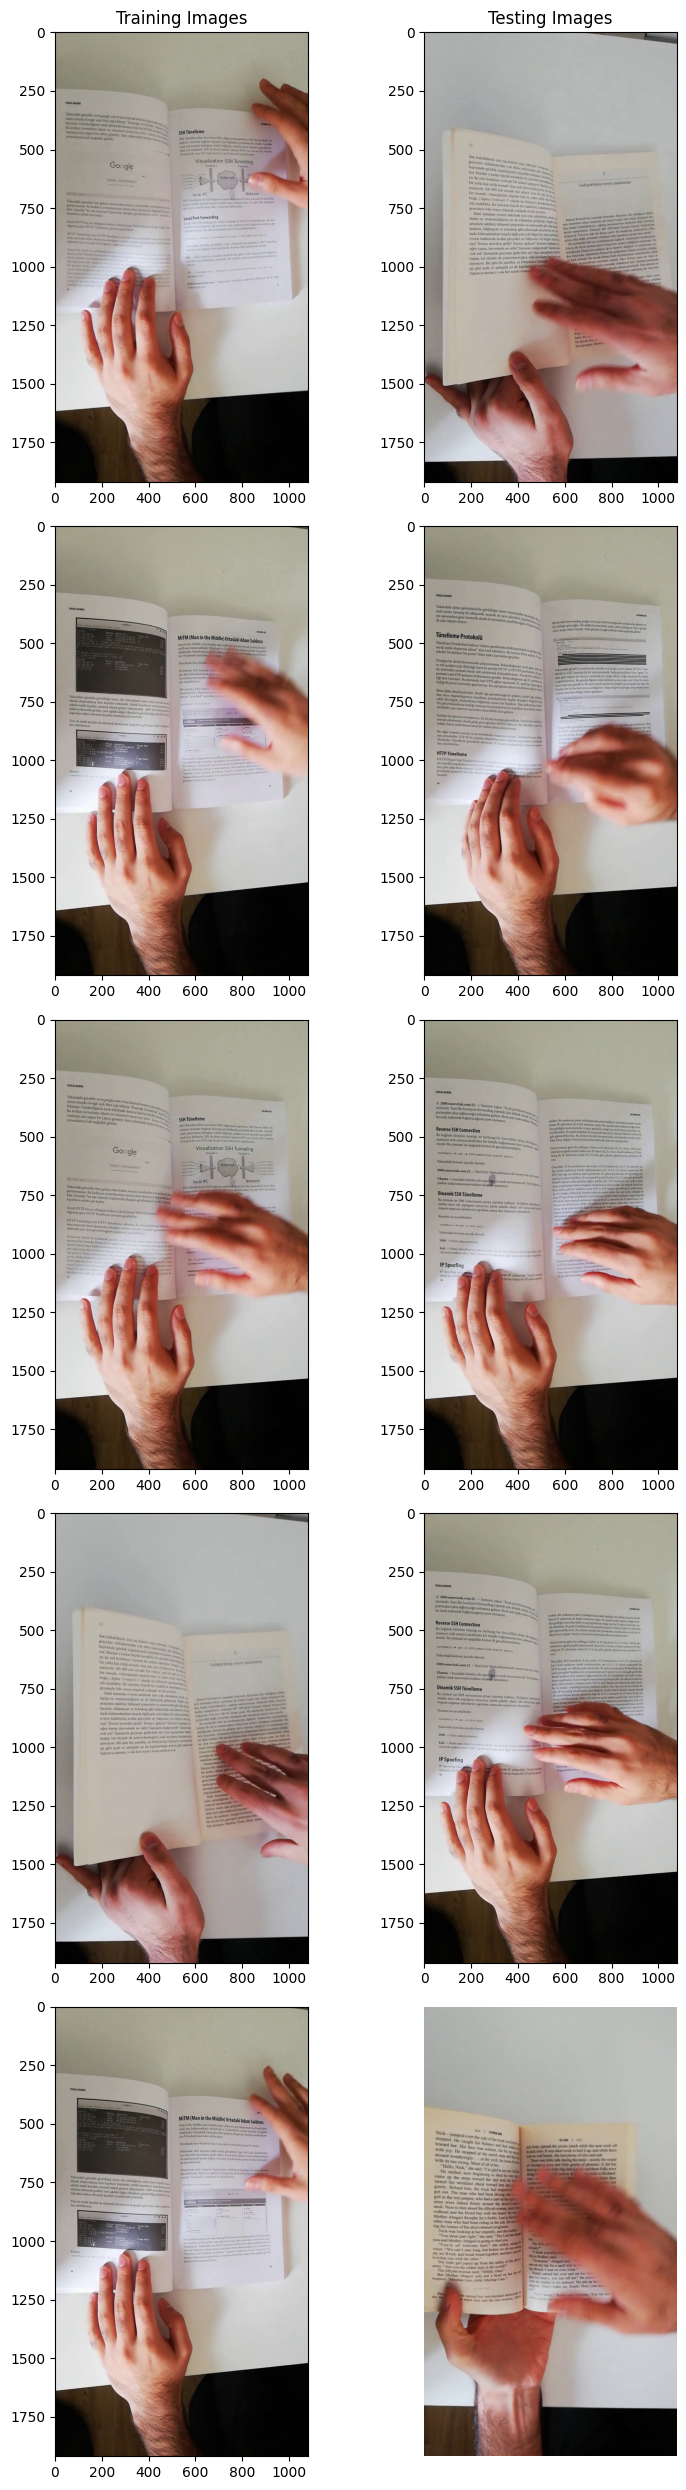

In [183]:
plot_no_flip_images(path_to_images='images', num_images=5)

## Convolutional Neural Network

https://medium.com/advanced-deep-learning/cnn-operation-with-2-kernels-resulting-in-2-feature-mapsunderstanding-the-convolutional-filter-c4aad26cf32

In [184]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision
from torchvision import datasets
from torchvision.io import decode_image
from torchvision.transforms import v2
from torchvision.models import resnet18, ResNet18_Weights, vgg16, VGG16_Weights, vgg19, VGG19_Weights, Inception_V3_Weights, Inception3

In [185]:
pre_trained_classification_models = {
    # 'GoogleNet': [Inception3, Inception_V3_Weights.DEFAULT],
    'ResNet': [resnet18, ResNet18_Weights.DEFAULT],
    'VGG16': [vgg16, VGG16_Weights.DEFAULT]
}

In [186]:
## pre-trained image classification models

def get_pre_trained_predictions(model, model_weights):
    '''
    -- Parameters --
    model: PyToch model
    model_weight: that models weights

    -- Returns --
    Out of the box model predicitons
    '''

    img = get_random_training_notflip_image('images')
    img = decode_image('images/training/notflip/'+img)

    try:
        model_ = model(init_weights=model_weights)
        model_.eval()
    except:
        model_ = model(weights=model_weights)
        model_.eval()

    preprocess = model_weights.transforms()

    batch = preprocess(img).unsqueeze(0)

    prediction = model_(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = model_weights.meta['categories'][class_id]
    print(f"{category_name}: {100*score:.1f}%")

In [187]:
for name, values in pre_trained_classification_models.items(): ## in this case values correspond to the model and its respective weights
    print(f"-- {name} --")
    get_pre_trained_predictions(values[0], values[1])

-- ResNet --
menu: 75.3%
-- VGG16 --
teddy: 0.1%


### Data Augmentation

In [189]:
## Data augmentation and normalization for training using version2 https://pytorch.org/vision/stable/transforms.html#v2-api-reference-recommended
## Just normalize for validation 
## other steps follow: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet
from torch.utils.data import SubsetRandomSampler, Subset, DataLoader, random_split

## in the need for more in-depth image augmentation, such as if the model is over-fitting.
data_transform = {
    'training': v2.Compose([
        v2.ToImage(),
        v2.Resize(size=(128, 128)),
        # v2.RandomHorizontalFlip(.3),
        v2.CenterCrop(size=128),
        # v2.RandomAutocontrast(),
        # v2.RandomRotation(degrees=35),
        # v2.RandomPerspective(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]),
'testing': v2.Compose([
    v2.ToImage(),
    v2.Resize(size=(128, 128)),
    v2.CenterCrop(128),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])}

data_dir = 'images/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transform[x]) for x in ['training', 'testing']}

## splits training images into a seperate validation set
train_split, val_split = random_split(image_datasets['training'], [.80, .20])

print(f'Length of training data: {len(train_split)}')
print(f'Length of validation data: {len(val_split)}')
print(f"Length of testing data: {len(image_datasets['testing'])}\n")

## dataloaders for training, validation, and testing
train_dataloader = DataLoader(train_split, batch_size=16, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_split, batch_size=16, shuffle=True, num_workers=4)
test_dataloader = DataLoader(image_datasets['testing'], batch_size=16, shuffle=True, num_workers=4)

print(f"Length of training dataloader: {len(train_dataloader)}")
print(f"Length of validation dataloader: {len(val_dataloader)}")
print(f"Length of testing dataloader: {len(test_dataloader)}\n")

dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'testing']}

print(f"Length of training dataset: {dataset_sizes['training']}")
print(f"Length of testing dataset: {dataset_sizes['testing']}")

imgs = image_datasets['training'].imgs
class_names = image_datasets['training'].classes

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Length of training data: 1914
Length of validation data: 478
Length of testing data: 597

Length of training dataloader: 120
Length of validation dataloader: 30
Length of testing dataloader: 38

Length of training dataset: 2392
Length of testing dataset: 597


In [190]:
image, label = next(iter(train_dataloader))
dim, height, width = image[0].shape

print('\nImage tensor shape from the training dataloader:')
print(image[0].shape)
print(f"\nDimension of image: {dim}, Height of image: {height}, Width of image: {width}")

Python(59744) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(59745) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(59746) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(59747) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Image tensor shape from the training dataloader:
torch.Size([3, 128, 128])

Dimension of image: 3, Height of image: 128, Width of image: 128


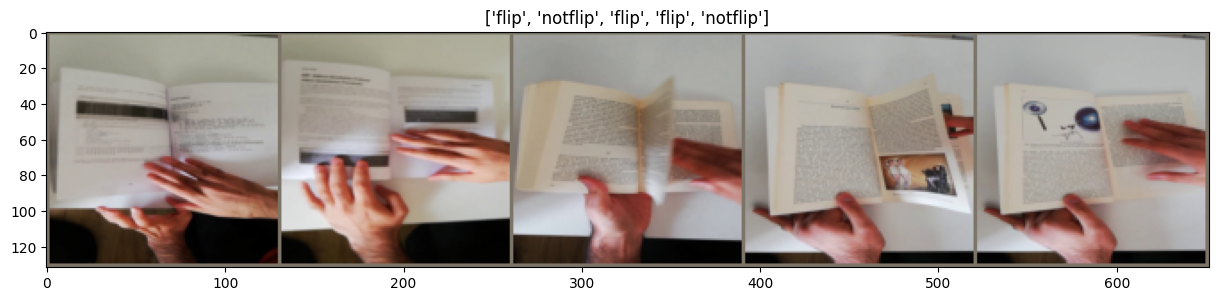

In [27]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.figure(figsize=(15,8))
    plt.imshow(inp)
    
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[:5])

imshow(out, title=[class_names[x] for x in classes[:5]])

Hyperparameters to tune:
* In the case of custom CNN:
    * number of convolutions
    * number of filters/convolution (add or subtract features)
    * padding, stride, and kernel size
    * types of pooling layers (maxpool, averagepool)
    * activation functions (ReLU, LeakyReLU, etc.)

* In the case of fine tuning and custom:
    * learning rate (for both cost function as well as the features in the pre-trained CNN's)
    * optimizer (SGD, Adam, etc)
    * L2 Regularization (weight decay)
    * image size
    * image augmentation

In [37]:
class TNet(nn.Module):
    def __init__(self):
        super(TNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=5, stride=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(.20),

            nn.Conv2d(128, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64, affine=False),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Dropout(.20),

            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32, affine=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout(.20),

            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(16, affine=False),
            nn.AvgPool2d(kernel_size=2, stride=2),
            # nn.MaxPool2d(kernel_size=2, stride=2),

            # nn.Conv2d(16, 32, kernel_size=3, padding=1, bias=False),
            # nn.ReLU(inplace=True),

            # nn.Conv2d(32, 32, kernel_size=3, padding=1, bias=False),
            # nn.ReLU(inplace=True),
            # nn.AvgPool2d(kernel_size=2, stride=2),
            # nn.MaxPool2d(kernel_size=2, stride=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(16*1*1, 32),
            nn.LeakyReLU(inplace=True),
            nn.Linear(32, 32),
            nn.LeakyReLU(inplace=True),
            # nn.Linear(32, 32),
            # nn.LeakyReLU(inplace=True),
            nn.Linear(32, 2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        # print(x.shape)
        x = x.view(-1, x.shape[1]*x.shape[2]*x.shape[3])
        x = self.linear_layers(x)
        return x

In [38]:
## https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    def __init__(self, patience=3, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [83]:
# SEED = torch.seed()
SEED = 14425870739644852099
print(f"Random PyTorch Seed: {SEED}")
manual_seed = torch.manual_seed(SEED)

Random PyTorch Seed: 14425870739644852099


In [85]:
model = TNet()
# optimizer = optim.SGD(params=model.parameters() , lr=0.0001, momentum=0.9, weight_decay=.1)
optimizer = optim.AdamW(model.parameters(), lr=.001)
criterion = nn.CrossEntropyLoss()
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [191]:
##### for visualizing the feature maps from the convolusions during training...code from ChatGPT

# # Step 2: Initialize model and set to evaluation mode
# model = TNet()
# model.eval()

# image_path = get_random_training_notflip_image('images/')  # Replace with your image path
# image = Image.open('images/training/notflip/'+image_path)
# image = compose(image).unsqueeze(0)  # Add batch dimension

# # Step 4: Hook a convolutional layer to extract feature maps
# activation = {}

# def hook_fn(module, input, output):
#     activation["conv3"] = output.detach()

# model.conv1.register_forward_hook(hook_fn)

# # Step 5: Perform a forward pass
# _ = model(image)

# # Step 6: Get the feature maps
# feature_maps = activation["conv3"].squeeze(0).cpu().numpy()  # Remove batch dimension

# # Step 7: Visualize the first 6 feature maps
# fig, axes = plt.subplots(1, len(feature_maps), figsize=(15, 5))
# for i, ax in enumerate(axes):
#     ax.imshow(feature_maps[i], cmap='viridis')
#     ax.axis("off")
#     ax.set_title(f"Filter {i+1}")

# plt.show()

In [87]:
def train(model, optimizer, criterion, scheduler, early_stopping=False, epochs=25):
    '''
    -- Parameters --
    model: PyTorch ConvNet
    optimizer: PyTorch optimizer, e.g. Adam, AdamW, SGD.
    criterion: PyTorch loss function, e.g. CrossEntropyLoss.
    scheduler: PyTorch learning rate scheduler
    early_stopping: Set to True if you want early stopping enabled. Default = False
    epochs: Number of epochs to train. Default = 25

    -- Returns --
    the average training and validation losses as well as the training and validation accuracy scores from each epoch

    '''

    ## initiates early stopper
    if early_stopping == True:
        early_stopper = EarlyStopper(patience=4)

    dataloader_length = int(len(train_dataloader))
    val_dataloader_length = int(len(val_dataloader))

    ## initializes the losses and accuracies at 50%
    losses = [0.5]
    accuracy_scores = [0.5]
    val_losses = [0.5]
    val_accuracies = [0.5]

    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
        model.train()

        running_train_loss = 0.0
        running_val_loss = 0.0
        correct_preds = torch.tensor(0.0)
        correct_val_preds = torch.tensor(0.0)

        for i, (image, labels) in enumerate(train_dataloader):
            image = image.to(device)
            labels = labels.to(device).to(torch.float16).long()

            optimizer.zero_grad()

            outputs = model(image)

            _, preds = torch.max(outputs, 1)
            preds = preds.to(torch.float16)

            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()
            scheduler.step()

            ## running total of the loss value
            running_train_loss += loss.item()

            ## running total of the correct number of predictions in each batch
            correct_preds += torch.sum(preds == labels.data)

            if i+1 == dataloader_length:
                average_loss = running_train_loss/len(train_split)## average loss over the total 1914 images
                losses.append(average_loss)

                average_accuracy = correct_preds/len(train_split) ## average accuracy over the total 478 images
                accuracy_scores.append(average_accuracy)

        ## evaluation mode
        model.eval()
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_dataloader):
                vimages = images.to(device)
                vlabels = labels.to(device).to(torch.float16).long()

                voutputs = model(vimages)

                _, vpreds = torch.max(voutputs, 1)
                vpreds = vpreds.to(torch.float16)
                vloss = criterion(voutputs, vlabels)
    
                running_val_loss += vloss.item()
                correct_val_preds += torch.sum(vpreds == vlabels.data)

                if i+1 == val_dataloader_length:
                    average_val_loss = running_val_loss/len(val_split)
                    val_losses.append(average_val_loss)

                    average_val_accuracy = correct_val_preds/len(val_split)
                    val_accuracies.append(average_val_accuracy)

            # early stopping
            if early_stopper.early_stop(vloss.item()):
                print(f"Early stopping triggered after epoch {epoch+1}.")
                break

        print(f"Training loss:   {average_loss:.7f} || Training accuracy:   {average_accuracy:.7f}")
        print(f"Validation loss: {average_val_loss:.7f} || Validation accuracy: {average_val_accuracy:.7f}")
        print('-'*75)

    return losses, accuracy_scores, val_losses, val_accuracies

In [88]:
def test(model):
    '''
    -- Parameters --
    model: PyTorch ConvNet

    -- Returns --
    Prints out the labels, predictions, and the correct percentage of classifications
    
    '''

    model.eval()

    with torch.no_grad():
        images, labels = next(iter(test_dataloader))
        images = images.to(device)
        labels = labels.to(device).to(torch.float16).long()

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        equality = labels == preds
        percentage = torch.sum(equality)/len(labels)

        print(f"Labels:      {labels}")
        print(f"Predictions: {preds}")
        print(f"Correct percentage: {percentage}%")

In [89]:
losses, accuracies, val_losses, val_accuracies = train(model, optimizer, criterion, exp_lr_scheduler, early_stopping=True, epochs=25)

Epoch: 1
Training loss:   0.0431355 || Training accuracy:   0.6729363
Validation loss: 0.0432496 || Validation accuracy: 0.6338912
---------------------------------------------------------------------------
Epoch: 2
Training loss:   0.0431119 || Training accuracy:   0.6692790
Validation loss: 0.0432437 || Validation accuracy: 0.6380753
---------------------------------------------------------------------------
Epoch: 3
Training loss:   0.0431053 || Training accuracy:   0.6692790
Validation loss: 0.0432617 || Validation accuracy: 0.6422594
---------------------------------------------------------------------------
Epoch: 4
Early stopping triggered after epoch 4.


In [90]:
torch.save(model.state_dict(), f='TNet_state_dict.pt')

In [91]:
model = TNet()
model.load_state_dict(torch.load('TNet_state_dict.pt', weights_only=True))

<All keys matched successfully>

In [92]:
test(model)

Labels:      tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1])
Predictions: tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1])


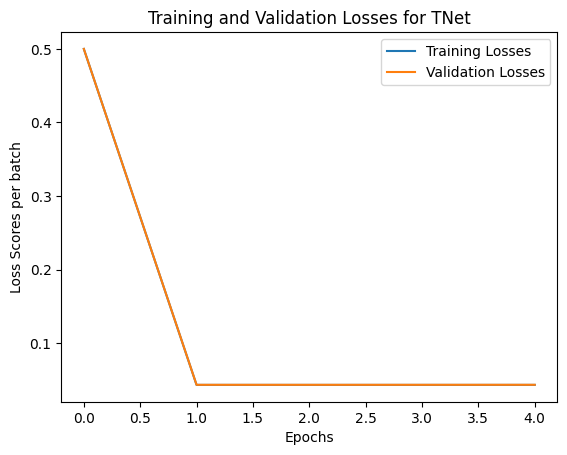

In [93]:
plt.plot(losses, label='Training Losses')
plt.plot(val_losses, label='Validation Losses')
plt.title('Training and Validation Losses for TNet')
plt.xlabel('Epochs')
plt.ylabel('Loss Scores per batch')
plt.legend()
plt.show()

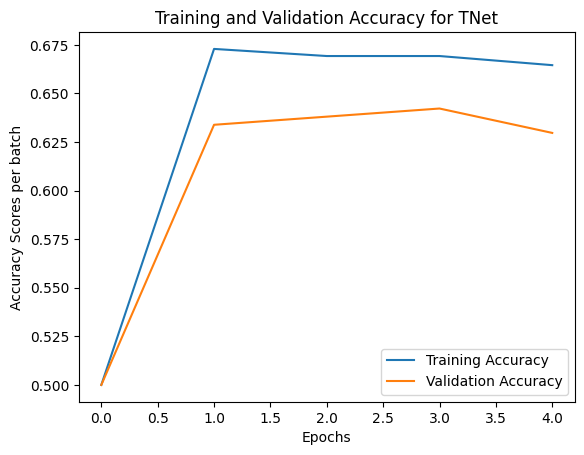

In [94]:
plt.plot(accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy for TNet')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Scores per batch')
plt.legend()
plt.show()

In [95]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                fig, ax = plt.subplots(nrows=num_images/2,
                                  ncols=2,
                                  )
                ax[j, 0] = imshow(inputs.cpu().data[j])
                ax[j, 1] = imshow(inputs.cpu().data[j])
                

                plt.axis('off')
                plt.tilte('Predictions vs Actual')
                plt.title(f"Actual: {class_names[labels[j]]}\nPredicted: {class_names[preds[j]]}")
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

In [96]:
# visualize_model(model)

In [100]:
def initialize_pre_trained_models(models=dict()):
    '''
    --Parameters--
    models: dictionary whose keys correspond to the names of the models and the values are a two item list that corresponds to the torchvision.model and that models DEFAULT weights
        i.e. 'model_name': [torchvision.models.{model}, torchvision.{model}.{model_weights}.DEFAULT]

    --Returns--
    the pre-trained models with: 
        1. all layers froze except for the last layer
        2. final layer changed to nn.Linear with 2 outputs
        3. DEFAULT weights
    '''

    models_dict = {}

    for name, values in models.items():
        print(f'-- {name} --')

        model_ = values[0]
        weights_ = values[1]

        # if name == 'GoogleNet':
        #     model_ = model_(init_weights=weights_)
        # else:
        #     model_ = model_(weights=weights_)
        model_ = model_(weights=weights_)

        # for param in model_.parameters():
        #     param.requires_grad = False

        if name == 'VGG16':
            ## freezing all but last two fully connected layers
            # for param in model_.classifier.parameters():
            #     param.requires_grad = True
            # top_4_fc_layers = list(model_.classifier.parameters())[:2]
            for param in model_.features.parameters():
                param.requires_grad = False

            num_fts = model_.classifier[-1].in_features
            model_.classifier[-1] = nn.Linear(num_fts, 2)

        else:
            for param in model_.fc.parameters():
                param.requires_grad = True

            num_fts = model_.fc.in_features
            model_.fc = nn.Linear(num_fts, 2)
            

        model_ = model_.to(device)
        models_dict[name] = model_

    return models_dict

In [101]:
models_dict = initialize_pre_trained_models(pre_trained_classification_models)

-- ResNet --
-- VGG16 --


In [192]:
## dump the pickled models_dict for use in other notebooks

import pickle

## pickling the whole dictionary with both ResNet and VGG16
# with open('data.pickle', 'wb') as handle:
#     pickle.dump(models_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

## pickles just the ResNet model
with open('resnet.pickle', 'wb') as handle:
    pickle.dump(models_dict['ResNet'], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [103]:
models_dict

{'ResNet': ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (r

In [105]:
resnet_optimizer = torch.optim.AdamW(params=models_dict['ResNet'].parameters(), lr=.001)
resnet_lr_scheduler = lr_scheduler.StepLR(resnet_optimizer, step_size=7, gamma=0.1)

vgg16_optimizer = torch.optim.AdamW(params=models_dict['VGG16'].parameters(), lr=.001)
vgg16_lr_scheduler = lr_scheduler.StepLR(vgg16_optimizer, step_size=7, gamma=0.1)

In [106]:
losses, train_acc, val_losses, val_acc = train(models_dict['ResNet'], resnet_optimizer, criterion=criterion, scheduler=resnet_lr_scheduler, early_stopping=True)

Epoch: 1
Training loss:   0.0250929 || Training accuracy:   0.8500522
Validation loss: 0.0123636 || Validation accuracy: 0.9184101
---------------------------------------------------------------------------
Epoch: 2
Training loss:   0.0183638 || Training accuracy:   0.8855799
Validation loss: 0.0120742 || Validation accuracy: 0.9330544
---------------------------------------------------------------------------
Epoch: 3
Training loss:   0.0184914 || Training accuracy:   0.8840125
Validation loss: 0.0117830 || Validation accuracy: 0.9309623
---------------------------------------------------------------------------
Epoch: 4
Training loss:   0.0179762 || Training accuracy:   0.8840125
Validation loss: 0.0123630 || Validation accuracy: 0.9246862
---------------------------------------------------------------------------
Epoch: 5
Early stopping triggered after epoch 5.


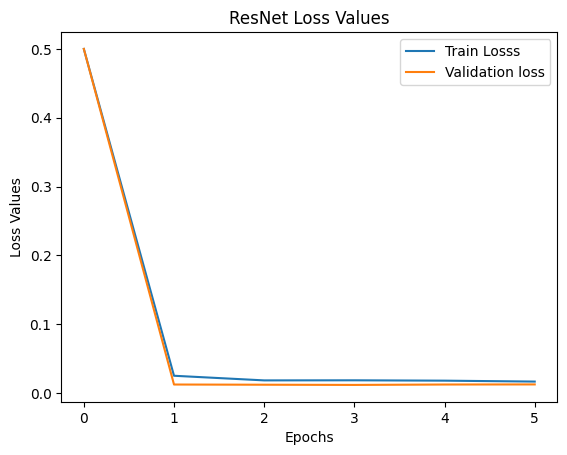

In [107]:
plt.plot(losses, label='Train Losss')
plt.plot(val_losses, label='Validation loss')
plt.title('ResNet Loss Values')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.show()

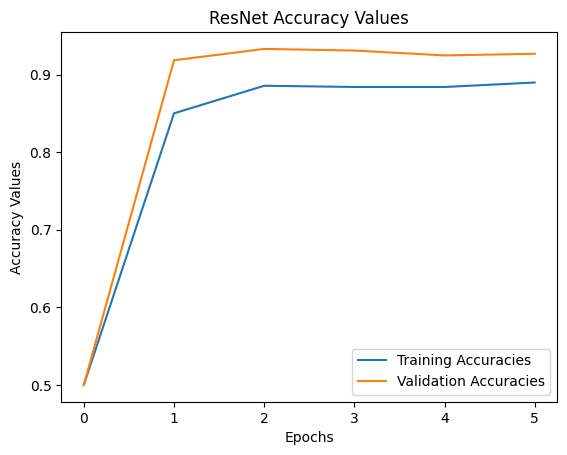

In [108]:
plt.plot(train_acc, label='Training Accuracies')
plt.plot(val_acc, label='Validation Accuracies')
plt.title('ResNet Accuracy Values')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy Values')
plt.show()

In [109]:
test(models_dict['ResNet'])

Labels:      tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])
Predictions: tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1])


In [110]:
torch.save(models_dict['ResNet'].state_dict(), 'resnet.pt')

In [118]:
resnet_model = models_dict['ResNet']

resnet_model.load_state_dict(torch.load('resnet.pt', weights_only=True))

test(resnet_model)

Labels:      tensor([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1])
Predictions: tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1])


In [119]:
losses, train_acc, val_losses, val_acc = train(models_dict['VGG16'], vgg16_optimizer, criterion=criterion, scheduler=vgg16_lr_scheduler, early_stopping=True)

Epoch: 1
Training loss:   0.0724984 || Training accuracy:   0.5804598
Validation loss: 0.0356898 || Validation accuracy: 0.6778243
---------------------------------------------------------------------------
Epoch: 2
Training loss:   0.0588207 || Training accuracy:   0.5898641
Validation loss: 0.0357536 || Validation accuracy: 0.6778243
---------------------------------------------------------------------------
Epoch: 3
Training loss:   0.0617657 || Training accuracy:   0.5747126
Validation loss: 0.0358068 || Validation accuracy: 0.6778243
---------------------------------------------------------------------------
Epoch: 4
Early stopping triggered after epoch 4.


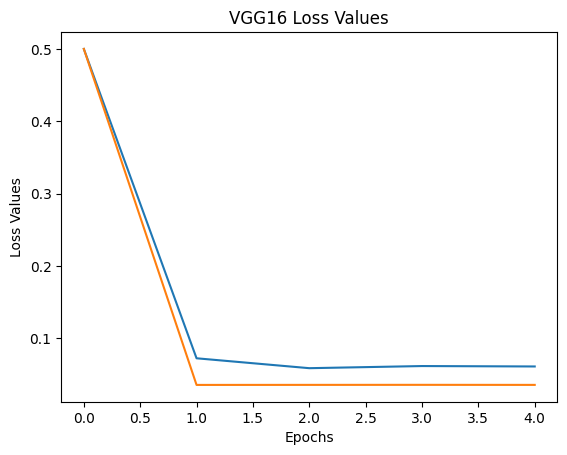

In [120]:
plt.plot(losses, label='Train Losss')
plt.plot(val_losses, label='Validation loss')
plt.title('VGG16 Loss Values')
plt.xlabel('Epochs')
plt.ylabel('Loss Values')
plt.show()

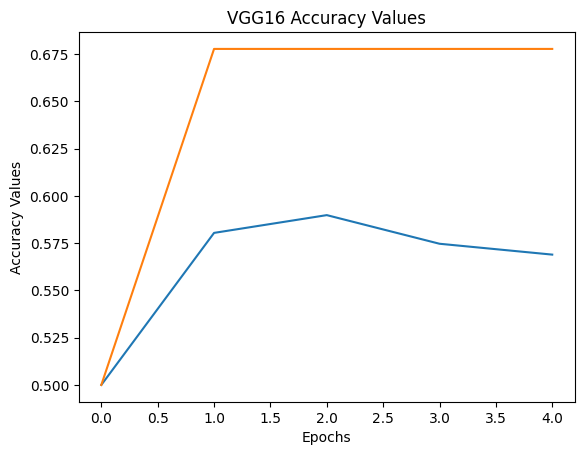

In [121]:
plt.plot(train_acc, label='Training Accuracies')
plt.plot(val_acc, label='Validation Accuracies')
plt.title('VGG16 Accuracy Values')
plt.xlabel('Epochs')
plt.ylabel('Accuracy Values')
plt.show()

In [122]:
test(models_dict['VGG16'])

Labels:      tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0])
Predictions: tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1])


In [123]:
torch.save(models_dict['VGG16'].state_dict(), f='VGG16_model.pt')

In [124]:
vgg16_model = models_dict['VGG16']

vgg16_model.load_state_dict(torch.load('VGG16_model.pt', weights_only=True))

test(vgg16_model)

Labels:      tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1])
Predictions: tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])


### Conclusion

After experimenting with a custom CNN architecture and pre-trained models, the best performance - in this case the metric we are looking at is accuracy, is shown to be with a fine-tuned ResNet model with over 90% on both training and validation sets.